# NLP - Clasificacion de Textos

## 1. Dataset elegido

El dataset elegido fue: **BBC Full Text Document Classification**. Este contiene articulos de:
- economia
- entretenimiento
- politica
- deporte
- tecnologia

El motivo de la eleccion fue que un dataset de este tipo de contenido nos facilitara la tarea de clasificar textos de tematica similar a la del dataset, como ser trabajos academicos de materias como economia general.
Si bien el dataset se encuentra en ingles, se puede pensar la posibilidad en un futuro de encontrar un corpus semejante en español y realizar la clasificacion en dicho idioma

El dataset es abierto y puede ser bajado desde la pagina de Kaggle: https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification

## 2. Bibliotecas Principales

- Para realizar el preprocesamiento del texto del corpus elegido utilizamos las funciones proporcionadas por **NLTK**. Posteriormente seran mencionadas las tecnicas de preprocesamiento.
- Elegimos **SKlearn** para la vectorizacion de los textos y para la clasificacion de los textos hacemos uso de cinco clasificadores diferentes

In [1]:
import pandas as pd
import numpy as np
import nltk

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

from functools import reduce
from collections import OrderedDict
import os
import re

## 3. Manejo del dataset

### 3.1. Importamos el dataset

Importamos todos los topicos mencionados del dataset y los guardamos en un diccionario

In [2]:
topics = ['business/', 'entertainment/', 'politics/', 'sport/', 'tech/']

paths = list(map(lambda topic: "bbc/" + topic, topics))

dataset = OrderedDict()

for topic_path in paths:
    path = topic_path
    dirs = os.listdir(path)
    topic_name = topic_path.split("/")[1]
    topic_data = []

    for file_name in dirs:
        file = open(path + file_name, "rb")
        topic_data.append(str(file.read(), encoding="utf-8", errors="ignore"))
        file.close()

    dataset[topic_name] = topic_data

### 3.2. Análisis preeliminar

Analizamos la cantidad de documentos por clase. Vemos que el dataset se encuentra considerablemente balanceado.

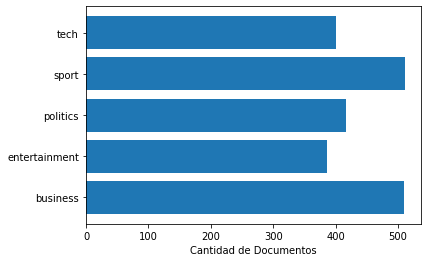

In [3]:
def flatten(l):
    return list(reduce(lambda a, b: a + b, l))

df = pd.DataFrame({
    'text': flatten([value for _, value in dataset.items()]), 
    'target': flatten(list([ [key] * len(values) for key, values in dataset.items() ]))
})

samples_per_class = df.groupby('target').count()

y_positions = np.arange(len(samples_per_class))
plt.barh(y_positions, samples_per_class['text'])
plt.yticks(y_positions, samples_per_class.index)
plt.xlabel('Cantidad de Documentos')
plt.show()

## 4. Preprocesamiento

### 4.1. Filtro de stopwords

Filtramos las palabras de los documentos que no proporcionen algun significado relevante, es decir, mantenemos solo las palabras que no sean stopwords.

In [4]:
not_letter_or_space = re.compile('[^a-z ]')
english_stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_text(document):
    document = document.lower()
    document = not_letter_or_space.sub('', document)
    document = ' '.join(word for word in nltk.tokenize.word_tokenize(document) if word not in english_stopwords)
    return document

df['text'] = df['text'].apply(clean_text)

### 4.2. Lematizacion

De todas las palabras filtradas por el paso anterior, procedemos a quedarnos con el lemma de cada una de ellas. El lemma es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra.

In [5]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(document):
    document = ' '.join(lemmatizer.lemmatize(word) for word in nltk.tokenize.word_tokenize(document))
    return document

df['text'] = df['text'].apply(lemmatize_text)

## 5. Vectorizacion

Vectorizamos los textos ya preprocesados para luego poder entrenar con los modelos de clasificacion que habremos elegido

El método de extracción fue TF-IDF (Term Frequency - Inverse Document Frequency). Genera un feature por palabra, siendo el valor de la misma el siguiente:

$$TF(Texto, Palabra) = cantidad\_de\_ocurrencias\_de\_Palabra\_en\_Texto$$

$$IDF(Palabra) = \log{\frac{cantidad\_de\_textos}{cantidad\_de\_textos\_que\_contienen\_Palabra}}$$

$$Feature(Texto, Palabra) = TF(TextO, Palabra) * IDF(Palabra)$$

In [6]:
vectorizer = TfidfVectorizer(ngram_range = (1,2), tokenizer = nltk.word_tokenize)
feature_matrix = vectorizer.fit_transform(df["text"])

## 6. Entrenamos y Testeamos

Testeamos los siguientes modelos:

* Maquina de Soporte Vectorial Lineal
* Naive Bayes
* K Nearest Neighbours (k = 10)
* Árbol de decisión
* Random Forest

In [7]:
model_names = np.array(['Linear SVM', 'Naive Bayes', 'KNN, k=10', 'Decision Tree', 'Random Forest'])
models = np.array([LinearSVC(), MultinomialNB(), KNeighborsClassifier(10), DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100)])

accuracies = []

for model_name, model in zip(model_names, models):
    X_train, X_test, Y_train, Y_test = train_test_split(
        feature_matrix, df["target"], test_size=0.3)
    model.fit(X_train, Y_train)
    predicted = model.predict(X_test)
    accuracy = accuracy_score(Y_test, predicted)
    accuracies.append(accuracy)

Mostramos la precision de cada uno de los clasificadores

Text(0, 0.5, 'Accuracy')

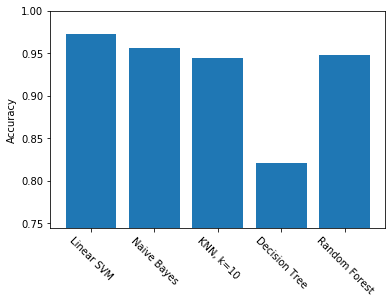

In [8]:
x_positions = np.arange(len(model_names))
min_value = min(accuracies)
max_value = max(accuracies)
y_lower = max(0.0, min_value - 0.5 * (max_value - min_value))
y_upper = min(1.0, max_value + 0.5 * (max_value - min_value))
plt.bar(x_positions, accuracies)
plt.ylim(y_lower, y_upper)
plt.xticks(x_positions, model_names, rotation=-45)
plt.ylabel('Accuracy')

Como podemos ver, la **máquina de soporte vectorial** y **Naive Bayes** obtienen consistentemente los mejores resultados, seguidos por **KNN** con k = 10, **Random Forest** con 100 estimadores obtiene resultados similares a KNN, pero generalmente un poco menores. El **árbol de decisión** no parece tan adecuado para esta clasificación, obteniendo una precisión entre un 14% y un 16% menor a los otros modelos testeados.

Observaciones

* Utilizar lematización disminuye ligeramente la precisión de la clasificación (promedia un 2% de disminución). Sin embargo, esperamos que la misma mejore el rendimiento de los modelos al clasificar textos no pertenecientes a este corpus

### 6.1. Cross Validation

In [11]:
model = LinearSVC()
cross_val_score(model, feature_matrix, df['target'], cv=10)

array([0.96444444, 0.98206278, 0.99103139, 0.97757848, 0.96412556,
       0.98654709, 0.95945946, 0.98190045, 0.99095023, 0.98190045])

### 7. Próximos Pasos
- Se puede pensar en elegir posteriormente un dataset en español. Esto es posible ya que los clasificadores presentados sirven para otros idiomas, ademas de que NLTK ofrecen stopwords del español
- Probar la utilización de document embeddings para la extracción de features en vez de la vectorización usando TfidfVectorizer.